In [1]:
import os, subprocess
import json
import uproot
import awkward as ak
import numpy as np
from coffea import processor, util, hist

%matplotlib inline
from matplotlib import lines as mlines
import matplotlib.pyplot as plt
from cycler import cycler

In [2]:
lumis = {}
lumis['2016'] = 35.9
lumis['2017'] = 41.5
lumis['2018'] = 59.9

nfiles = {}
nfiles['2016'] = 43
nfiles['2017'] = 43
nfiles['2018'] = 51

with open('xsec.json') as f:
  xs = json.load(f)

with open('pmap.json') as f:
  pmap = json.load(f)

In [3]:
# SPECIFY YEAR HERE
years = ['2016']
str_year = '2016'

In [4]:
outsum = processor.dict_accumulator()

for year in years:
    for n in range(1,nfiles[year]+1):
        out = util.load('condor/outfiles/'+year+'_'+str(n)+'.coffea')
        #print(out)
        outsum.add(out)
        
scale_lumi = {k: xs[k] * 1000 *lumis[year] / w for k, w in outsum['sumw'].items()}
outsum['templatesVBF'].scale(scale_lumi, 'dataset')

In [5]:
templates = outsum['templatesVBF'].group('dataset', hist.Cat('process', 'Process'), pmap)

In [6]:
templates = templates.integrate('mjj',int_range=slice(1000,4000)).integrate('deta',int_range=slice(3.5,7))

In [7]:
ptbins = [450, 500, 550, 600, 675, 800, 1200]

In [8]:
os.system('rm vbfregion.root')
fout = uproot.create('vbfregion.root')
for i,b in enumerate(ptbins[:-1]):
    for p in pmap.keys():  
        h = templates.sum('rho1').integrate('region', 'signal').integrate('pt1',int_range=slice(ptbins[i],ptbins[i+1])).integrate('ddb1',int_range=slice(0.89,1)).integrate('process',p)
        fout[p+"_pass_pt"+str(i+1)] = hist.export1d(h)
        h = templates.sum('rho1').integrate('region', 'signal').integrate('pt1',int_range=slice(ptbins[i],ptbins[i+1])).integrate('ddb1',int_range=slice(0,0.89)).integrate('process',p)
        fout[p+"_fail_pt"+str(i+1)] = hist.export1d(h)

fout.close()

In [9]:
os.system('rm vbfonebin.root')
fout = uproot.create('vbfonebin.root')
for p in pmap.keys():  
    h = templates.sum('rho1','pt1').integrate('region', 'signal').integrate('ddb1',int_range=slice(0.89,1)).integrate('process',p)
    fout[p+"_pass"] = hist.export1d(h)
    h = templates.sum('rho1','pt1').integrate('region', 'signal').integrate('ddb1',int_range=slice(0,0.89)).integrate('process',p)
    fout[p+"_fail"] = hist.export1d(h)

fout.close()

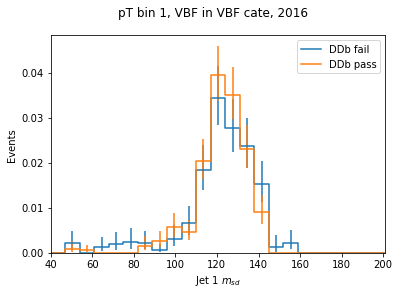

In [10]:
hist.plot1d(templates.sum('rho1').integrate('region', 'signal').integrate('pt1',int_range=slice(ptbins[0],ptbins[1])).integrate('process','VBF'),overlay='ddb1',density=True)
plt.suptitle("pT bin 1, VBF in VBF cate, "+str_year)
plt.legend(["DDb fail","DDb pass"])
plt.savefig('plot-'+str_year+'/vbf-msd-pt1.png')

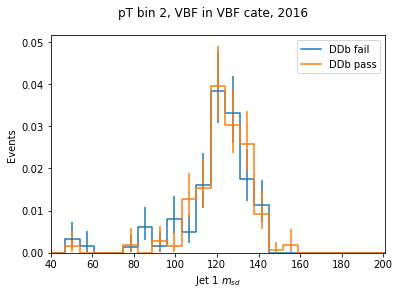

In [11]:
hist.plot1d(templates.sum('rho1').integrate('region', 'signal').integrate('pt1',int_range=slice(ptbins[1],ptbins[2])).integrate('process','VBF'),overlay='ddb1',density=True)
plt.suptitle("pT bin 2, VBF in VBF cate, "+str_year)
plt.legend(["DDb fail","DDb pass"])
plt.savefig('plot-'+str_year+'/vbf-msd-pt2.png')

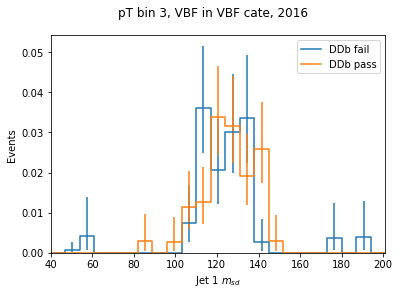

In [12]:
hist.plot1d(templates.sum('rho1').integrate('region', 'signal').integrate('pt1',int_range=slice(ptbins[2],ptbins[3])).integrate('process','VBF'),overlay='ddb1',density=True)
plt.suptitle("pT bin 3, VBF in VBF cate, "+str_year)
plt.legend(["DDb fail","DDb pass"])
plt.savefig('plot-'+str_year+'/vbf-msd-pt3.png')

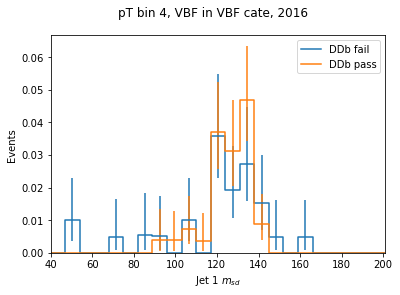

In [13]:
hist.plot1d(templates.sum('rho1').integrate('region', 'signal').integrate('pt1',int_range=slice(ptbins[3],ptbins[4])).integrate('process','VBF'),overlay='ddb1',density=True)
plt.suptitle("pT bin 4, VBF in VBF cate, "+str_year)
plt.legend(["DDb fail","DDb pass"])
plt.savefig('plot-'+str_year+'/vbf-msd-pt4.png')

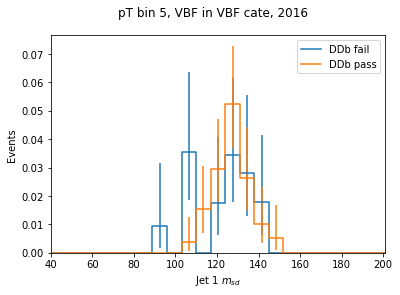

In [14]:
hist.plot1d(templates.sum('rho1').integrate('region', 'signal').integrate('pt1',int_range=slice(ptbins[4],ptbins[5])).integrate('process','VBF'),overlay='ddb1',density=True)
plt.suptitle("pT bin 5, VBF in VBF cate, "+str_year)
plt.legend(["DDb fail","DDb pass"])
plt.savefig('plot-'+str_year+'/vbf-msd-pt5.png')

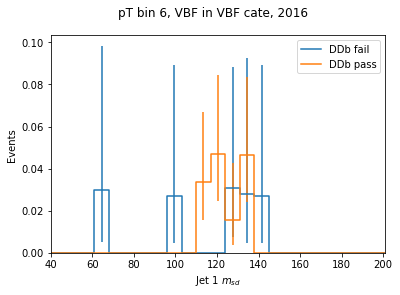

In [15]:
hist.plot1d(templates.sum('rho1').integrate('region', 'signal').integrate('pt1',int_range=slice(ptbins[5],ptbins[6])).integrate('process','VBF'),overlay='ddb1',density=True)
plt.suptitle("pT bin 6, VBF in VBF cate, "+str_year)
plt.legend(["DDb fail","DDb pass"])
plt.savefig('plot-'+str_year+'/vbf-msd-pt6.png')

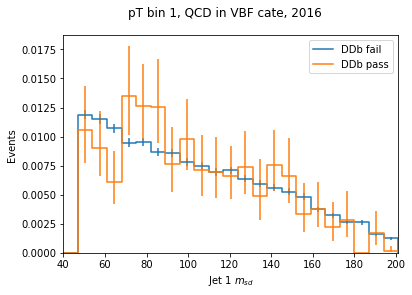

In [16]:
hist.plot1d(templates.sum('rho1').integrate('region', 'signal').integrate('pt1',int_range=slice(ptbins[0],ptbins[1])).integrate('process','QCD'),overlay='ddb1',density=True)
plt.suptitle("pT bin 1, QCD in VBF cate, "+str_year)
plt.legend(["DDb fail","DDb pass"])
plt.savefig('plot-'+str_year+'/qcd-msd-pt1.png')

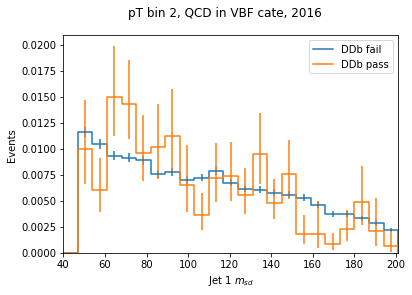

In [17]:
hist.plot1d(templates.sum('rho1').integrate('region', 'signal').integrate('pt1',int_range=slice(ptbins[1],ptbins[2])).integrate('process','QCD'),overlay='ddb1',density=True)
plt.suptitle("pT bin 2, QCD in VBF cate, "+str_year)
plt.legend(["DDb fail","DDb pass"])
plt.savefig('plot-'+str_year+'/qcd-msd-pt2.png')

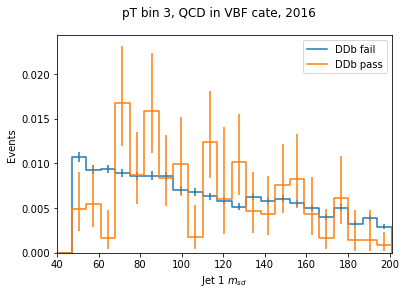

In [18]:
hist.plot1d(templates.sum('rho1').integrate('region', 'signal').integrate('pt1',int_range=slice(ptbins[2],ptbins[3])).integrate('process','QCD'),overlay='ddb1',density=True)
plt.suptitle("pT bin 3, QCD in VBF cate, "+str_year)
plt.legend(["DDb fail","DDb pass"])
plt.savefig('plot-'+str_year+'/qcd-msd-pt3.png')

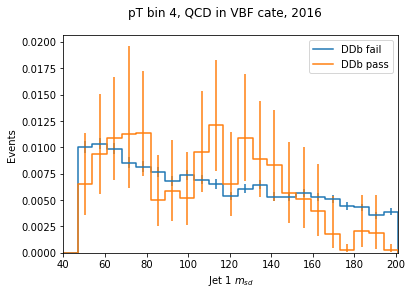

In [19]:
hist.plot1d(templates.sum('rho1').integrate('region', 'signal').integrate('pt1',int_range=slice(ptbins[3],ptbins[4])).integrate('process','QCD'),overlay='ddb1',density=True)
plt.suptitle("pT bin 4, QCD in VBF cate, "+str_year)
plt.legend(["DDb fail","DDb pass"])
plt.savefig('plot-'+str_year+'/qcd-msd-pt4.png')

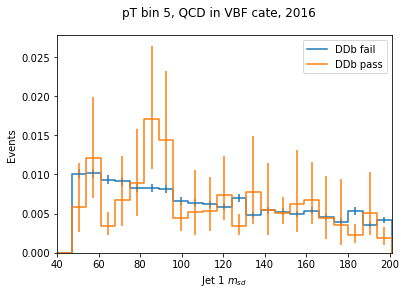

In [20]:
hist.plot1d(templates.sum('rho1').integrate('region', 'signal').integrate('pt1',int_range=slice(ptbins[4],ptbins[5])).integrate('process','QCD'),overlay='ddb1',density=True)
plt.suptitle("pT bin 5, QCD in VBF cate, "+str_year)
plt.legend(["DDb fail","DDb pass"])
plt.savefig('plot-'+str_year+'/qcd-msd-pt5.png')

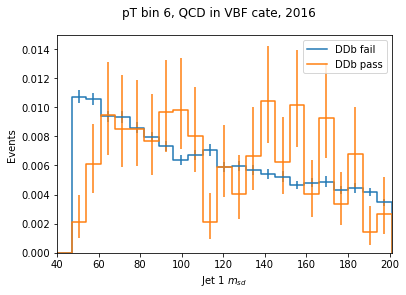

In [21]:
hist.plot1d(templates.sum('rho1').integrate('region', 'signal').integrate('pt1',int_range=slice(ptbins[5],ptbins[6])).integrate('process','QCD'),overlay='ddb1',density=True)
plt.suptitle("pT bin 6, QCD in VBF cate, "+str_year)
plt.legend(["DDb fail","DDb pass"])
plt.savefig('plot-'+str_year+'/qcd-msd-pt6.png')

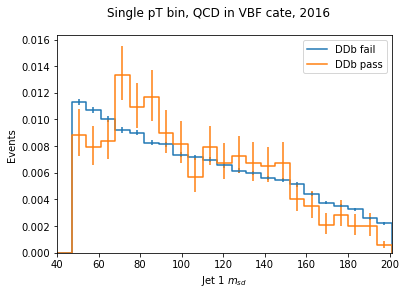

In [22]:
hist.plot1d(templates.sum('rho1','pt1').integrate('region', 'signal').integrate('process','QCD'),overlay='ddb1',density=True)
plt.suptitle("Single pT bin, QCD in VBF cate, "+str_year)
plt.legend(["DDb fail","DDb pass"])
plt.savefig('plot-'+str_year+'/qcd-msd.png')